The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6


# The Object Detection Dataset

There are no small datasets, like MNIST or Fashion-MNIST, in the object detection field. In order to quickly test models, we are going to assemble a small dataset. First, we generate 1000 Pikachu images of different angles and sizes using an open source 3D Pikachu model. Then, we collect a series of background images and place a Pikachu image at a random position on each image. We use the [im2rec tool](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) provided by MXNet to convert the images to binary RecordIO format[1]. This format can reduce the storage overhead of the dataset on the disk and improve the reading efficiency. If you want to learn more about how to read images, refer to the documentation for the [GluonCV Toolkit](https://gluon-cv.mxnet.io/).


## Downloading the Dataset

The Pikachu dataset in RecordIO format can be downloaded directly from the Internet.

In [1]:
%matplotlib inline
import d2l
from mxnet import gluon, image, np, npx
import os

npx.set_np()

# Saved in the d2l package for later use
d2l.DATA_HUB['pikachu'] = (d2l.DATA_URL + 'pikachu.zip',
                           '68ab1bd42143c5966785eb0d7b2839df8d570190')

## Reading the Dataset

We are going to read the object detection dataset by creating the instance `ImageDetIter`. The "Det" in the name refers to Detection. We will read the training dataset in random order. Since the format of the dataset is RecordIO, we need the image index file `'train.idx'` to read random minibatches. In addition, for each image of the training set, we will use random cropping and require the cropped image to cover at least 95% of each object. Since the cropping is random, this requirement is not always satisfied. We preset the maximum number of random cropping attempts to 200. If none of them meets the requirement, the image will not be cropped. To ensure the certainty of the output, we will not randomly crop the images in the test dataset. We also do not need to read the test dataset in random order.

In [2]:
# Saved in the d2l package for later use
def load_data_pikachu(batch_size, edge_size=256):
    """Load the pikachu dataset."""
    data_dir = d2l.download_extract('pikachu')
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # The shape of the output image
        shuffle=True,  # Read the dataset in random order
        rand_crop=1,  # The probability of random cropping is 1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

Below, we read a minibatch and print the shape of the image and label. The shape of the image is the same as in the previous experiment (batch size, number of channels, height, width). The shape of the label is (batch size, $m$, 5), where $m$ is equal to the maximum number of bounding boxes contained in a single image in the dataset. Although computation for the minibatch is very efficient, it requires each image to contain the same number of bounding boxes so that they can be placed in the same batch. Since each image may have a different number of bounding boxes, we can add illegal bounding boxes to images that have less than $m$ bounding boxes until each image contains $m$ bounding boxes. Thus, we can read a minibatch of images each time. The label of each bounding box in the image is represented by an array of length 5. The first element in the array is the category of the object contained in the bounding box. When the value is -1, the bounding box is an illegal bounding box for filling purpose. The remaining four elements of the array represent the $x, y$ axis coordinates of the upper-left corner of the bounding box and the $x, y$ axis coordinates of the lower-right corner of the bounding box (the value range is between 0 and 1). The Pikachu dataset here has only one bounding box per image, so $m=1$.

In [3]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

## Demonstration

We have ten images with bounding boxes on them. We can see that the angle, size, and position of Pikachu are different in each image. Of course, this is a simple artificial dataset. In actual practice, the data are usually much more complicated.

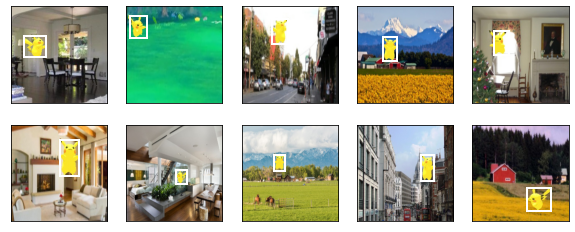

In [4]:
imgs = (batch.data[0][0:10].transpose(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Summary

* The Pikachu dataset we synthesized can be used to test object detection models.
* The data reading for object detection is similar to that for image classification. However, after we introduce bounding boxes, the label shape and image augmentation (e.g., random cropping) are changed.


## Exercises

1. Referring to the MXNet documentation, what are the parameters for the constructors of the `image.ImageDetIter` and `image.CreateDetAugmenter` classes? What is their significance?

## [Discussions](https://discuss.mxnet.io/t/2452)

![](../img/qr_object-detection-dataset.svg)